In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%pylab inline
from math import sin, cos, sqrt, atan2, radians
pd.set_option('precision', 2)

Populating the interactive namespace from numpy and matplotlib


DEFINING CONSTANTS

In [44]:
#range of hours considered
lower_limit_time_range=1200
upper_limit_time_range=1400
line_frequency_bound=10

In [116]:
# https://catalogodatos.gub.uy/dataset/horarios-omnibus-urbanos-por-parada-stm
bus_schedules_by_stops = pd.read_csv('files/uptu_pasada_variante.csv',sep=';')

#transfers_with_no_max.query('')
#line_id_1_var_01

#display(bus_schedules_by_stops.query('cod_variante==666' 
#                                     #+
#                                    # 'and ordinal ==1 and hora >= 1000 and hora <= 1400'
#                                    ))


bus_schedules_by_stops.head()

,tipo_dia,cod_variante,frecuencia,cod_ubic_parada,ordinal,hora,dia_anterior
0,1,7929,9230,6301,1,923,N
1,1,7929,9230,6196,2,924,N
2,1,7929,9230,2315,3,925,N
3,1,7929,9230,2316,4,926,N
4,1,7929,9230,2317,5,926,N


In [114]:
# https://catalogodatos.gub.uy/dataset/horarios-omnibus-urbanos-por-parada-stm
uptu_pasada_circular = pd.read_csv('files/uptu_pasada_circular.csv',sep=';')

#transfers_with_no_max.query('')
#line_id_1_var_01


uptu_pasada_circular.head()


#uptu_pasada_circular.csv

,tipo_dia,cod_circular,frecuencia,cod_ubic_parada,cod_variante,parte,ordinal,hora,dia_anterior
0,1,1,6050,2611,237,1,51,701,N
1,1,1,6050,2610,237,1,50,700,N
2,1,1,6050,2609,237,1,49,700,N
3,1,1,6050,2608,237,1,48,659,N
4,1,1,6050,4890,237,1,26,639,N


In [47]:
# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
stops_ubication = gpd.read_file('files/v_uptu_paradas.shx')
stops_ubication = pd.DataFrame(stops_ubication)
stops_ubication.head()
#stops_ubication.query('COD_UBIC_P ==2447 and COD_VARIAN==1276' )
#stops_ubication.query('COD_UBIC_P ==4212 and COD_VARIAN==170' )

,COD_UBIC_P,DESC_LINEA,COD_VARIAN,ORDINAL,CALLE,ESQUINA,COD_CALLE1,COD_CALLE2,X,Y,geometry
0,546.0,144,883,43,CORUÃA,PURIFICACION,2187,5733,578023.60,6.14e+06,POINT (578023.60011 6140711.3452)
1,546.0,144,3225,45,CORUÃA,PURIFICACION,2187,5733,578023.60,6.14e+06,POINT (578023.60011 6140711.3452)
2,547.0,144,883,44,CORUÃA,SAN ANTONIO,2187,6279,577944.25,6.14e+06,POINT (577944.25345 6140828.51804)
3,547.0,144,3225,46,CORUÃA,SAN ANTONIO,2187,6279,577944.25,6.14e+06,POINT (577944.25345 6140828.51804)
4,548.0,144,888,20,CORUÃA,SAN ANTONIO,2187,6279,577926.51,6.14e+06,POINT (577926.50589 6140844.77825)


In [117]:
# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
recorridos_omnibus = gpd.read_file('files/v_uptu_lsv.dbf')
recorridos_omnibus = pd.DataFrame(recorridos_omnibus)
recorridos_omnibus.head()

#recorridos_omnibus.query('COD_VARIAN==1737')
#recorridos_omnibus.query('DESC_LINEA=="L1"')



,GID,COD_LINEA,DESC_LINEA,ORDINAL_SU,COD_SUBLIN,DESC_SUBLI,COD_VARIAN,DESC_VARIA,geometry
0,1.60e+07,0,LINEA CERO,1,0,SUBLINEA CERO,0,None,None
1,1.60e+07,1,402,1,1,CIUDAD VIEJA - MALVIN,8,A,None
2,1.60e+07,2,404,1,2,CJO.J.AMÃRICA - PCIO.DE LA LUZ,14,B,None
3,1.60e+07,2,404,1,2,CJO.J.AMÃRICA - PCIO.DE LA LUZ,20,A,None
4,1.60e+07,3,405,1,3,PEÃAROL - PARQUE RODÃ,24,B,None


In [49]:
# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
ubicacion_puntos_control = gpd.read_file('files/v_uptu_controles.dbf')
ubicacion_puntos_control = pd.DataFrame(ubicacion_puntos_control)
ubicacion_puntos_control.head()

,COD_UBIC_C,DESC_LINEA,COD_VARIAN,ORDINAL,DESC_UBIC_,COD_CALLE1,COD_CALLE2,X,Y,geometry
0,1,402,1,10,MALVIN,7569,240,581831.11,6.14e+06,None
1,1,G,3401,2,MALVIN,7569,240,581831.11,6.14e+06,None
2,1,G,3402,11,MALVIN,7569,240,581831.11,6.14e+06,None
3,1,2,7565,2,MALVIN,7569,240,581831.11,6.14e+06,None
4,1,2,7566,8,MALVIN,7569,240,581831.11,6.14e+06,None


In [50]:
# https://catalogodatos.gub.uy/dataset/lineas-omnibus-origen-y-destino
origen_destino_lineas = gpd.read_file('files/v_uptu_lsv_destinos.dbf')
origen_destino_lineas = pd.DataFrame(origen_destino_lineas)
origen_destino_lineas.head()

,GID,COD_LINEA,DESC_LINEA,ORDINAL_SU,COD_SUBLIN,DESC_SUBLI,COD_VARIAN,DESC_VARIA,COD_VAR_01,COD_ORIGEN,DESC_ORIGE,COD_DESTIN,DESC_DESTI,geometry
0,1.60e+07,1,402,1,1,CIUDAD VIEJA - MALVIN,8,A,NaN,19,PLAYA MALVÃN,23,CIUDAD VIEJA,None
1,1.60e+07,2,404,1,2,CJO.J.AMÃRICA - PCIO.DE LA LUZ,14,B,NaN,69,PALACIO DE LA LUZ,47,COMPLEJO JUANA DE AMÃRICA,None
2,1.60e+07,2,404,1,2,CJO.J.AMÃRICA - PCIO.DE LA LUZ,20,A,NaN,47,COMPLEJO JUANA DE AMÃRICA,69,PALACIO DE LA LUZ,None
3,1.60e+07,3,405,1,3,PEÃAROL - PARQUE RODÃ,24,B,NaN,56,PARQUE RODÃ,74,PEÃAROL,None
4,1.60e+07,3,405,2,246,GRUTA DE LOURDES - PARQUE RODO,28,B,NaN,56,PARQUE RODÃ,5,GRUTA DE LOURDES,None


In [51]:
# https://catalogodatos.gub.uy/dataset/lineas-omnibus-origen-y-destino
recorridos_variantes_no_maximales = gpd.read_file('files/uptu_variante_no_maximal.dbf')
recorridos_variantes_no_maximales = pd.DataFrame(recorridos_variantes_no_maximales)
recorridos_variantes_no_maximales.head()

#stops_ubication.query('COD_UBIC_P ==2447 and COD_VARIAN==1276' )


,GID,COD_VARIAN,COD_VAR_01,DESC_VARIA,COD_UBIC_P,COD_UBI_01,ORDINAL_OR,ORDINAL_DE,geometry
0,4.62e+07,5,1,B,6092.0,3252.0,50,73,None
1,4.62e+07,6,1,B,3520.0,3252.0,30,73,None
2,4.62e+07,7,1,B,4041.0,2912.0,1,66,None
3,4.62e+07,15,14,B,3922.0,3207.0,1,39,None
4,4.62e+07,17,14,B,6091.0,2474.0,40,47,None


demand for defined period

In [111]:
#range of hours considered
#lower_limit_time_range=1100
#upper_limit_time_range=1400

# https://catalogodatos.gub.uy/dataset/lineas-omnibus-origen-y-destino
#file_name='files/trasbordos_' + str(lower_limit_time_range) + '_' + str(upper_limit_time_range) +'.csv'
file_name='files/trasbordos.csv'
transfers = pd.read_csv(file_name,sep=',')

#transfers['stop_line_1'] = transfers['stop_id_1'] + transfers['line_id_1']
display(transfers.head())

transfers.columns = ['stop_id_1','stop_id_2','line_id_1','line_id_2','n_transfers']

display(transfers.head())


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers
0,2427,2426,1096,2579,309
1,1885,4468,1759,1667,204
2,1108,4775,1122,650,186
3,1942,4399,1759,987,165
4,4212,5709,170,2579,149


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers
0,2427,2426,1096,2579,309
1,1885,4468,1759,1667,204
2,1108,4775,1122,650,186
3,1942,4399,1759,987,165
4,4212,5709,170,2579,149


## comienza el procesameinto >>>>>>>>>>>>>>>>>>>>

SALIDA: que son??

4 3 //cantidad_de_lineas puntos_sincro

1 2 2 100 3 10 15 16 0 // linea1 linea2 dist_entre_paradas P wb Wb TTl1 TTl2 es_bachin

2 3 1  50 5  8 18 22 0

3 4 1  75 5  8 18 22 0

5 15

4 12

4 10

4 10


In [95]:
cod_variante_validas= bus_schedules_by_stops.query('ordinal==1').copy()
cod_variante_validas['count'] = 1
#fecuencias_validas.head()
cod_variante_validas = cod_variante_validas.groupby('cod_variante').sum().reset_index()
cod_variante_validas.mean()
#fecuencias_validas.std()
cod_variante_validas=cod_variante_validas[cod_variante_validas['count'] > line_frequency_bound]['cod_variante']
cod_variante_validas.head()

0     1
1     8
2    14
3    17
4    20
Name: cod_variante, dtype: int64

merge transfers with no maximal lines

In [96]:
transfers_with_no_max = transfers.copy()
transfers_with_no_max =  pd.merge(transfers_with_no_max, recorridos_variantes_no_maximales, 
                 how='left', left_on=['line_id_1'], right_on=['COD_VARIAN'])
transfers_with_no_max = transfers_with_no_max[['stop_id_1','stop_id_2',
                                               'line_id_1','line_id_2','n_transfers',
                                              'COD_VAR_01',]]
transfers_with_no_max.columns = ['stop_id_1','stop_id_2',
                                               'line_id_1','line_id_2','n_transfers',
                                              'line_id_1_var_01',]

transfers_with_no_max =  pd.merge(transfers_with_no_max, recorridos_variantes_no_maximales, 
                 how='left', left_on=['line_id_2'], right_on=['COD_VARIAN'])
transfers_with_no_max = transfers_with_no_max[['stop_id_1','stop_id_2',
                                               'line_id_1','line_id_2','n_transfers','line_id_1_var_01',
                                              'COD_VAR_01',]]
transfers_with_no_max.columns = ['stop_id_1','stop_id_2',
                                               'line_id_1','line_id_2','n_transfers',
                                              'line_id_1_var_01','line_id_2_var_01',]


complete maximals

In [97]:
transfers_with_no_max['line_id_1_var_01'] =\
            transfers_with_no_max.apply(lambda e: e.line_id_1 
                                        if math.isnan(e.line_id_1_var_01)
                                        else e.line_id_1_var_01,axis = 1) 
    
transfers_with_no_max['line_id_2_var_01'] =\
            transfers_with_no_max.apply(lambda e: e.line_id_2 
                                        if math.isnan(e.line_id_2_var_01) 
                                        else e.line_id_2_var_01,axis = 1) 




calculate tt

In [98]:
bus_schedules_by_stops = bus_schedules_by_stops[bus_schedules_by_stops['cod_variante'].isin(cod_variante_validas)] 
transfers_with_no_max = transfers_with_no_max[transfers_with_no_max['line_id_1'].isin(cod_variante_validas)] 
transfers_with_no_max = transfers_with_no_max[transfers_with_no_max['line_id_2'].isin(cod_variante_validas)] 

#display(transfers_with_no_max.head())
#transfers_with_no_max = transfers_with_no_max2[



#2352
#time1-time2
def diff(time1,time2):
    hours1 = time1 // 100
    minutes1 = time1 % 100
    hours2 = time2 // 100
    minutes2 = time2 % 100
    minutos_desde_la_cero_hora1=hours1*60+minutes1
    minutos_desde_la_cero_hora2=hours2*60+minutes2
    return minutos_desde_la_cero_hora2 - minutos_desde_la_cero_hora1

def ttaux(frecuencia,bus_in):
    bus=bus_in.copy()
    bus=bus[bus.ordinal == 1]
    bus=bus[bus['frecuencia'] ==  frecuencia]
    bus=bus[bus['tipo_dia'] ==  1]
    bus=bus[bus['dia_anterior'] ==  'N']
    
    bus=bus.iloc[0]
    #display(bus)
    #display(bus)
    return bus['hora'].copy()


def tt(linea,parada,bus_schedules_by_stops):

    #linea=170
    #parada=4212
    #display(linea)
    #display(parada)
    query='cod_variante=='+ str(linea)# +' and cod_ubic_parada == '+str(parada)
    bus_schedules_by_stops_aux = bus_schedules_by_stops.query(query).copy()
    aux1=bus_schedules_by_stops_aux.copy()
    
    query='cod_variante=='+ str(linea) +' and cod_ubic_parada == '+str(parada)
    aux2 = bus_schedules_by_stops.query(query).copy()
    
    #display(aux2)
    
    aux2 = aux2.query('tipo_dia == 1').copy()
       
    frecuencias_validas_horarios= aux1.query('tipo_dia == 1 and ordinal==1 and hora >=' +
                                             str(lower_limit_time_range-400) +
                                            'and hora <= ' + str(upper_limit_time_range+400)
                                            )
    
    aux1 = aux1[aux1['frecuencia'].isin(frecuencias_validas_horarios['frecuencia'])]
    aux2 = aux2[aux2['frecuencia'].isin(frecuencias_validas_horarios['frecuencia'])]
    #aux2 = aux2.query('frecuencia == 7070')
    
    if (aux2.size>0):
        
        #display(aux2)
        aux2['hora_salida'] =\
        aux2.apply(lambda e: ttaux(e.frecuencia,aux1),axis = 1) 

        #display(aux2)
        aux2['TT'] =\
            aux2.apply(lambda e: diff(e.hora_salida,e.hora),axis = 1) 
        aux2 =\
        aux2.groupby(['tipo_dia','cod_variante','cod_ubic_parada']).mean().reset_index()


        #display(aux2)
        query='cod_variante=='+ str(linea) +' and cod_ubic_parada == '+str(parada)#+' and tipo_dia == 1 '
        return aux2.query(query)['TT']
    else:
        return -1
    
    #return 1
#display(bus_schedules_by_stops_aux) [bus['line_id_1'] ==  170]
transfers_with_no_max2 = transfers_with_no_max#[transfers_with_no_max['line_id_1'] ==  170].copy()
transfers_with_no_max2['TT1'] =\
        transfers_with_no_max2.apply(lambda e: tt(e.line_id_1_var_01,e.stop_id_1,bus_schedules_by_stops),axis = 1).copy() 
transfers_with_no_max2['TT2'] =\
        transfers_with_no_max2.apply(lambda e: tt(e.line_id_2_var_01,e.stop_id_2,bus_schedules_by_stops),axis = 1).copy() 

##deleting out-of-range lines 
transfers_with_no_max2 = transfers_with_no_max2.query('TT1!= -1 and TT2!=-1')

display(transfers_with_no_max2)
transfers_with_no_max = transfers_with_no_max2

#display(bus_schedules_by_stops.query('cod_variante==1667 and ordinal == 1'))




/home/jon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01,TT1,TT2
0,2427,2426,1096,2579,309,1096.0,1311.0,23.12,21.78
1,1885,4468,1759,1667,204,1759.0,1667.0,18.33,0.00
2,1108,4775,1122,650,186,1122.0,650.0,20.62,15.35
3,1942,4399,1759,987,165,1759.0,982.0,26.33,12.00
4,4212,5709,170,2579,149,170.0,1311.0,21.75,12.00
5,2447,2437,1276,1092,148,1274.0,1092.0,50.50,37.75
7,2427,2426,1096,1290,136,1096.0,1282.0,23.12,23.80
9,4843,4930,1122,1347,128,1122.0,1347.0,22.62,17.13


merge transfers and stops ubication to get stops geometriy (coordinates)

In [99]:
transfers_with_stop_coors = transfers_with_no_max.copy()
transfers_with_stop_coors =  pd.merge(transfers_with_stop_coors, stops_ubication, 
                 how='left', left_on=['stop_id_1','line_id_1_var_01'], right_on=['COD_UBIC_P',
                                                                                 'COD_VARIAN'])


transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1','line_id_2','stop_id_1',
                                                       'stop_id_2','line_id_1_var_01',
                                                         'line_id_2_var_01','n_transfers','geometry','TT1','TT2']]



transfers_with_stop_coors.columns = ['line_id_1','line_id_2','stop_id_1','stop_id_2',
                                     'line_id_1_var_01','line_id_2_var_01','n_transfers',
                                      'line_1_geometry','TT1','TT2']


transfers_with_stop_coors = pd.merge(transfers_with_stop_coors, stops_ubication, 
                 how='left', left_on=['stop_id_2','line_id_2_var_01'], right_on=['COD_UBIC_P',
                                                                                 'COD_VARIAN'])


transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1','line_id_2','stop_id_1',
                                                       'stop_id_2','line_id_1_var_01',
                                                         'line_id_2_var_01','n_transfers',
                                                       'line_1_geometry','geometry','TT1','TT2']]

transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1',
                                                         'line_id_2','n_transfers',
                                                         'line_1_geometry',
                                                         'geometry','TT1','TT2']]
transfers_with_stop_coors.columns = ['line_id_1',
                                    'line_id_2','n_transfers','line_1_geometry',
                                    'line_2_geometry','TT1','TT2']
display(transfers_with_stop_coors)

,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,TT1,TT2
0,1096,2579,309,POINT (574358.64012 6142007.80678),POINT (574335.992349177 6142073.73086134),23.12,21.78
1,1759,1667,204,POINT (579143.19729 6151045.05149),POINT (579003.43819 6150897.89783),18.33,0.00
2,1122,650,186,POINT (568274.43675 6140874.33485),POINT (568313.75044208 6140712.23252608),20.62,15.35
3,1759,987,165,POINT (576647.11472 6148135.18576),POINT (576591.86934 6148055.24203),26.33,12.00
4,170,2579,149,POINT (571782.139845352 6142120.25843186),POINT (571879.0758399999 6142165.71392),21.75,12.00
5,1276,1092,148,POINT (574419.2876644752 6142043.651997477),POINT (574338.72252 6141670.17293),50.50,37.75
6,1096,1290,136,POINT (574358.64012 6142007.80678),POINT (574335.992349177 6142073.73086134),23.12,23.80
7,1122,1347,128,POINT (568550.168073634 6140749.17301807),POINT (568630.045883108 6140710.86058456),22.62,17.13


caculate distance between stops of lines

In [100]:
def dist(geometry_1,geometry_2):
    return geometry_1.distance(geometry_2)

transfers_with_stop_coors['dist'] =\
transfers_with_stop_coors.apply(lambda e:dist(e.line_1_geometry,e.line_2_geometry),axis = 1) 
transfers_with_stop_coors.head(20)

,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,TT1,TT2,dist
0,1096,2579,309,POINT (574358.64012 6142007.80678),POINT (574335.992349177 6142073.73086134),23.12,21.78,69.71
1,1759,1667,204,POINT (579143.19729 6151045.05149),POINT (579003.43819 6150897.89783),18.33,0.00,202.95
2,1122,650,186,POINT (568274.43675 6140874.33485),POINT (568313.75044208 6140712.23252608),20.62,15.35,166.80
3,1759,987,165,POINT (576647.11472 6148135.18576),POINT (576591.86934 6148055.24203),26.33,12.00,97.18
4,170,2579,149,POINT (571782.139845352 6142120.25843186),POINT (571879.0758399999 6142165.71392),21.75,12.00,107.06
5,1276,1092,148,POINT (574419.2876644752 6142043.651997477),POINT (574338.72252 6141670.17293),50.50,37.75,382.07
6,1096,1290,136,POINT (574358.64012 6142007.80678),POINT (574335.992349177 6142073.73086134),23.12,23.80,69.71
7,1122,1347,128,POINT (568550.168073634 6140749.17301807),POINT (568630.045883108 6140710.86058456),22.62,17.13,88.59


intersection points

In [236]:
points = transfers_with_stop_coors[['line_id_1','line_id_2','dist','n_transfers','TT1','TT2']]
points.columns = ['line_i','line_j','dist','demand','TT_i','TT_j']
points.insert(4, 'wb',5)
points.insert(5, 'wB', 10)
#points.insert(6, 'TT_i', np.zeros(len(points)))
#points.insert(7, 'TT_j', np.zeros(len(points)))
points.insert(8, 'BP', np.zeros(len(points)))
points.head(60)

,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,1096,2579,69.71,309,5,10,23.12,21.78,0.0
1,1759,1667,202.95,204,5,10,18.33,0.00,0.0
2,1122,650,166.80,186,5,10,20.62,15.35,0.0
3,1759,987,97.18,165,5,10,26.33,12.00,0.0
4,170,2579,107.06,149,5,10,21.75,12.00,0.0
5,1276,1092,382.07,148,5,10,50.50,37.75,0.0
6,1096,1290,69.71,136,5,10,23.12,23.80,0.0
7,1122,1347,88.59,128,5,10,22.62,17.13,0.0


frequency

In [237]:
#display(frequency.head(60))

#bus_schedules_by_stops 
def max_min_avg_line_frec( linea ,bus_schedules_by_stops,lower_limit_time_range,upper_limit_time_range):
    resultado=bus_schedules_by_stops.query('tipo_dia==1 and ordinal==1 and dia_anterior== "N" and cod_variante=='+str(linea)+
                                           ' and hora>='+str(lower_limit_time_range-400)+' and hora<='
                                           +str(upper_limit_time_range+400))
    resultadoHoraTolistSinRepetidos=list(set(resultado.hora.tolist()))
    resultadoHoraTolistSinRepetidos = sorted(resultadoHoraTolistSinRepetidos)
    cant_rows = len(resultadoHoraTolistSinRepetidos)
    
    maxima_fecuencia = 0
    minima_frecuencia = 10000000
    lista_frecuencias_minutos_linea=[]
    #print(cant_rows)
    
    for i in range(cant_rows-1):
        time1=resultadoHoraTolistSinRepetidos[i]
        time2=resultadoHoraTolistSinRepetidos[i+1]
        hours1 = time1 // 100
        minutes1 = time1 % 100
        hours2 = time2 // 100
        minutes2 = time2 % 100
        minutos_desde_la_cero_hora1=hours1*60+minutes1
        minutos_desde_la_cero_hora2=hours2*60+minutes2
        resta = minutos_desde_la_cero_hora2-minutos_desde_la_cero_hora1
        lista_frecuencias_minutos_linea.append(resta)
        if(maxima_fecuencia<resta):
            maxima_fecuencia=resta
        #if(resta==1 and linea==1096):
        #    print(time1)
        #    print(time2)
        
    #elimina los duplicados    
    lista_frecuencias_minutos_linea = list(set(lista_frecuencias_minutos_linea)) 
  
    #print(linea)    
    #print(lista_frecuencias_minutos_linea)
    #print(resultado)
    retornero =	{
      "min": min(lista_frecuencias_minutos_linea),
      "max": maxima_fecuencia,
      "avg": sum(lista_frecuencias_minutos_linea)/len(lista_frecuencias_minutos_linea)
    }
    return retornero

lista_min = []
lista_max = []
lista_avg = []
lineas_en_orden_procesado=[]



# list of used stops
aux_lines_i =  pd.DataFrame({'linea': points['line_i'] })
aux_lines_j =  pd.DataFrame({'linea': points['line_j'] })
aux_lines = aux_lines_i.append(aux_lines_j)
aux_lines = aux_lines.drop_duplicates(subset=None, keep='first', inplace=False)
frequency = aux_lines.copy()

#display(lista_linea)

for i in range(len(frequency)):
   lista_linea=frequency.linea.tolist()
   min_max_promedio= max_min_avg_line_frec(lista_linea[i],bus_schedules_by_stops,lower_limit_time_range,upper_limit_time_range)
   lista_min.append(min_max_promedio["min"])
   lista_max.append(min_max_promedio["max"])
   lista_avg.append(min_max_promedio["avg"])
   lineas_en_orden_procesado.append(lista_linea[i])
    
lineas_min_max_avg=pd.DataFrame({'linea': lineas_en_orden_procesado, 'h': lista_min, 'H': lista_max, 'avg': lista_avg})

frec_h_H_avg =  pd.merge(frequency, lineas_min_max_avg, 
                 how='left', left_on=['linea'], right_on=['linea'])

display(frec_h_H_avg)  

,linea,h,H,avg
0,1096,5,24,12.79
1,1759,15,29,21.64
2,1122,7,18,11.70
3,170,7,12,9.50
4,1276,2,12,6.90
5,2579,3,13,7.90
6,1667,8,20,11.60
7,650,6,16,10.67
8,987,7,28,15.71
9,1092,6,23,13.47


calculate W w

In [238]:
points_merge_frec_h_H_avg_i= pd.merge(points, frec_h_H_avg, 
                           how='left', left_on=['line_i'], right_on=['linea'])

points_merge_frec_h_H_avg_j= pd.merge(points, frec_h_H_avg, 
                           how='left', left_on=['line_j'], right_on=['linea'])

#muestro tabla de frequencys para parejas de lineas
frecueni_j=pd.DataFrame({'line_i': points.line_i.tolist(),
                     'line_j': points.line_j.tolist(),
                     'h_i': points_merge_frec_h_H_avg_i.h.tolist(),
                     'Hi': points_merge_frec_h_H_avg_i.H.tolist(),
                     'h_j': points_merge_frec_h_H_avg_j.h.tolist(),
                     'Hj': points_merge_frec_h_H_avg_j.H.tolist(),
                     'avg_i': points_merge_frec_h_H_avg_i.avg.tolist(),
                     'avg_j': points_merge_frec_h_H_avg_j.avg.tolist()
                      
                      }) 


display(frecueni_j)

#wb es el minimo de los h de las dos lineas del punto
minimasFrecs=[]
for i in range(len(frecueni_j)):
    minimasFrecs.append(min(points_merge_frec_h_H_avg_i.h.tolist()[i],points_merge_frec_h_H_avg_j.h.tolist()[i]))

#display(frec_h_H_avg.H.tolist())
#display(points_merge_frec_h_H_avg)
#wB se setea por el H de la frequency 
points=pd.DataFrame({'line_i': points.line_i.tolist(),
                     'line_j': points.line_j.tolist(),
                     'dist': points.dist.tolist(),
                     'demand': points.demand.tolist(),
                     'wb': minimasFrecs,
                     'wB': points_merge_frec_h_H_avg_j.H.tolist(),
                     'TT_i': points.TT_i.tolist(),
                     'TT_j': points.TT_j.tolist(),
                     'BP': points.BP.tolist(),
                      })  
display(points)

,line_i,line_j,h_i,Hi,h_j,Hj,avg_i,avg_j
0,1096,2579,5,24,3,13,12.79,7.90
1,1759,1667,15,29,8,20,21.64,11.60
2,1122,650,7,18,6,16,11.70,10.67
3,1759,987,15,29,7,28,21.64,15.71
4,170,2579,7,12,3,13,9.50,7.90
5,1276,1092,2,12,6,23,6.90,13.47
6,1096,1290,5,24,4,12,12.79,7.86
7,1122,1347,7,18,4,16,11.70,9.92


,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,1096,2579,69.71,309,3,13,23.12,21.78,0.0
1,1759,1667,202.95,204,8,20,18.33,0.00,0.0
2,1122,650,166.80,186,6,16,20.62,15.35,0.0
3,1759,987,97.18,165,7,28,26.33,12.00,0.0
4,170,2579,107.06,149,3,13,21.75,12.00,0.0
5,1276,1092,382.07,148,2,23,50.50,37.75,0.0
6,1096,1290,69.71,136,4,12,23.12,23.80,0.0
7,1122,1347,88.59,128,4,16,22.62,17.13,0.0


mapping

In [239]:
#recorrer frec_h_H_avg y agregar columna
#luego agregar nuevas columnas a points

mapeo_linea_id=[]
#se construye mapeo
rango_lineas_procesadas= range(0,len(frec_h_H_avg))
lista_lineas=frec_h_H_avg.linea.tolist()  
mapeo_linea_id=pd.DataFrame({'linea': lista_lineas, 'id': rango_lineas_procesadas})    

frec_h_H_avg_map =  pd.merge(frec_h_H_avg, mapeo_linea_id, 
                 how='left', left_on=['linea'], right_on=['linea'])




#crear nuevo dataframe con el mismo nombre de clumna del join ahorra que agregue columnas que no se usan
mapeo_linea_id_i=pd.DataFrame({'line_i': lista_lineas, 'id_i': rango_lineas_procesadas})    


points_map_i =  pd.merge(points, mapeo_linea_id_i, 
                 how='inner', left_on=['line_i'], right_on=['line_i'])


#crear nuevo dataframe con el mismo nombre de clumna del join ahorra que agregue columnas que no se usan
mapeo_linea_id_j=pd.DataFrame({'line_j': lista_lineas, 'id_j': rango_lineas_procesadas})    

points_map_i_j =  pd.merge(points_map_i, mapeo_linea_id_j, 
                 how='inner', left_on=['line_j'], right_on=['line_j'])



#display(frec_h_H_avg_map)

#display(points_map_i_j)

#construye nuevo dataframe con las columnas en otro orden

points_con_ids=pd.DataFrame({'line_i': points_map_i_j.id_i.tolist(),
                             'line_j': points_map_i_j.id_j.tolist(),
                             'dist': points_map_i_j.dist.tolist(),
                             'demand': points_map_i_j.demand.tolist(),
                             'wb': points_map_i_j.wb.tolist(),
                             'wB': points_map_i_j.wB.tolist(),
                             'TT_i': points_map_i_j.TT_i.tolist(),
                             'TT_j': points_map_i_j.TT_j.tolist(),
                             'BP': points_map_i_j.BP.tolist(),
                              })  
display(points_con_ids)

frec_h_H_avg_ids=pd.DataFrame({'linea': frec_h_H_avg_map.id.tolist(),
                               'h': frec_h_H_avg_map.h.tolist(),
                               'H': frec_h_H_avg_map.H.tolist(),
                               'avg': frec_h_H_avg_map.avg.tolist()
                              })  
display(frec_h_H_avg_ids)
frec_h_H_avg_ids.round(2)

redondeado_points_con_ids=points_con_ids.round(2)
redondeado_frec_h_H_avg_ids=frec_h_H_avg_ids.round(2)


redondeado_frec_h_H_avg_ids.to_csv("frecuencias.csv", sep='\t', encoding='utf-8', index=False, header=False)

redondeado_points_con_ids.to_csv("points.csv", sep='\t', encoding='utf-8', index=False, header=False)


,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,0,5,69.71,309,3,13,23.12,21.78,0.0
1,3,5,107.06,149,3,13,21.75,12.00,0.0
2,0,10,69.71,136,4,12,23.12,23.80,0.0
3,1,6,202.95,204,8,20,18.33,0.00,0.0
4,1,8,97.18,165,7,28,26.33,12.00,0.0
5,2,7,166.80,186,6,16,20.62,15.35,0.0
6,2,11,88.59,128,4,16,22.62,17.13,0.0
7,4,9,382.07,148,2,23,50.50,37.75,0.0


,linea,h,H,avg
0,0,5,24,12.79
1,1,15,29,21.64
2,2,7,18,11.70
3,3,7,12,9.50
4,4,2,12,6.90
5,5,3,13,7.90
6,6,8,20,11.60
7,7,6,16,10.67
8,8,7,28,15.71
9,9,6,23,13.47


file wrinting

In [240]:
frec_h_H_avg_ids_to_file=pd.DataFrame({
                            # 'linea': frec_h_H_avg_map.id.tolist(),
                               'h': frec_h_H_avg_map.h.tolist(),
                               'H': frec_h_H_avg_map.H.tolist()
                            #  , 'avg': frec_h_H_avg_map.avg.tolist()
                              })  
redondeado_points_con_ids=points_con_ids.round(2)
redondeado_frec_h_H_avg_ids_to_file=frec_h_H_avg_ids_to_file.round(2)
redondeado_frec_h_H_avg_ids_to_file.to_csv("frecuencias.csv", sep='\t', 
                                           encoding='utf-8', index=False, header=False)
redondeado_points_con_ids.to_csv("points.csv", sep='\t', encoding='utf-8', index=False, header=False)

current system solution

In [367]:
current_solution_aux = bus_schedules_by_stops.copy()


frecuencias_validas_horarios= current_solution_aux.query('tipo_dia == 1 and ordinal==1 and hora >=' +
                                             str(lower_limit_time_range-400) +
                                            'and hora <= ' + str(upper_limit_time_range+400)
                                            )
current_solution_aux = current_solution_aux[current_solution_aux['frecuencia'].isin(
    frecuencias_validas_horarios['frecuencia'])]
current_solution_aux = current_solution_aux.query('ordinal == 1 and tipo_dia==1')
current_solution_aux['siguiente'] = current_solution_aux.hora.shift(-1)
current_solution_aux['diff'] = current_solution_aux.apply(lambda e:diff(
    e.hora,e.siguiente),axis = 1) 

current_solution_aux = current_solution_aux[current_solution_aux['cod_variante'].isin(frec_h_H_avg['linea'])]
current_solution_aux = current_solution_aux[current_solution_aux['diff'] > 0]
current_solution_aux = current_solution_aux.groupby('cod_variante').mean().reset_index()


frec_h_H_avg_aux =  pd.merge(frequency, current_solution_aux, 
                 how='left', left_on=['linea'], right_on=['cod_variante']).copy()



display(frec_h_H_avg_aux)

frec_h_H_avg_aux = frec_h_H_avg_aux[['diff']]


frec_h_H_avg_aux=frec_h_H_avg_aux.round(0)

current_solution_aux = frec_h_H_avg_aux
current_solution_aux_imm = current_solution_aux
#current_solution_aux.group('cod_variante').avg




,linea,cod_variante,tipo_dia,frecuencia,cod_ubic_parada,ordinal,hora,siguiente,diff
0,1096,1096,1.0,12184.31,2756.0,1.0,1221.81,1238.03,10.02
1,1759,1759,1.0,12590.34,5568.0,1.0,1259.03,1292.07,20.62
2,1122,1122,1.0,12196.33,4135.0,1.0,1220.95,1236.83,9.88
3,170,170,1.0,12659.68,4135.0,1.0,1267.58,1283.00,9.61
4,1276,1276,1.0,12843.03,3461.0,1.0,1286.67,1296.28,5.98
5,2579,2579,1.0,12414.43,5709.0,1.0,1241.44,1251.28,6.12
6,1667,1667,1.0,12637.97,4468.0,1.0,1263.80,1279.85,9.95
7,650,650,1.0,12354.43,1044.0,1.0,1235.44,1248.97,8.39
8,987,987,1.0,12458.26,1988.0,1.0,1245.83,1266.57,12.91
9,1092,1092,1.0,12833.23,4041.0,1.0,1283.32,1299.35,9.58


current system solution to file

In [356]:
frec_h_H_avg_aux.to_csv("real_timetable", sep='\t', encoding='utf-8', index=False, header=False)


fitness current system

In [357]:
display(frec_h_H_avg_ids_to_file.head(20))
display(points_con_ids.head(50))
display(current_solution_aux.head(20))

,h,H
0,5,24
1,15,29
2,7,18
3,7,12
4,2,12
5,3,13
6,8,20
7,6,16
8,7,28
9,6,23


,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,0,5,69.71,309,3,13,23.12,21.78,0.0
1,3,5,107.06,149,3,13,21.75,12.00,0.0
2,0,10,69.71,136,4,12,23.12,23.80,0.0
3,1,6,202.95,204,8,20,18.33,0.00,0.0
4,1,8,97.18,165,7,28,26.33,12.00,0.0
5,2,7,166.80,186,6,16,20.62,15.35,0.0
6,2,11,88.59,128,4,16,22.62,17.13,0.0
7,4,9,382.07,148,2,23,50.50,37.75,0.0


,diff
0,10.0
1,21.0
2,10.0
3,10.0
4,6.0
5,6.0
6,10.0
7,8.0
8,13.0
9,10.0


fitness

In [358]:
#d = {'diff': [6,21,15,7,11,9,20,9,22,20,8,7,]}
#d = {'diff': [5,15,7,9,2,8,8,14,7,19,6,4,]}
#current_solution_aux = pd.DataFrame(data=d)

#display()

SPEED = 6
suma = 0
for i in range(points_con_ids.shape[0]): # For each synchronization point
    line_i = points_con_ids.line_i[i]
    line_j = points_con_ids.line_j[i]
    #print(line_j)
    
    TT_i = points_con_ids.TT_i[i]
    TT_j = points_con_ids.TT_j[i]
    t_dist = (points_con_ids.dist[i]/1000/SPEED*60);
    
    t_dist = math.ceil(t_dist)
       
    demand = points_con_ids.demand[i]

    w_b = points_con_ids.wb[i]
    W_b = points_con_ids.wB[i]

    
    if ( ( ( (current_solution_aux['diff'][line_j]+TT_j) - 
            (current_solution_aux['diff'][line_i]+TT_i)) >= t_dist )
    and ( ( (current_solution_aux['diff'][line_j]+TT_j) -
             (current_solution_aux['diff'][line_i]+TT_i)) <= W_b + t_dist) ):
    
        print('----')
        print(line_i)
        print(line_j)
        #print(current_solution_aux['diff'][line_j]+TT_j)
        print('----')
        suma = suma + demand;
print(suma)    


0


improved fitness


In [411]:
#current_solution_aux = current_solution_aux_imm # fitness 28924
#current_solution_aux = pd.DataFrame(data={'diff': [6,21,15,7,11,9,20,9,22,20,8,7,]}) #  fitness 24669
current_solution_aux = pd.DataFrame(data={'diff': [5,16,7,7,2,3,8,6,7,6,4,4,]}) #  fitness 24669
#current_solution_aux = pd.DataFrame(data={'diff': [5,15,7,9,2,8,8,14,7,19,6,4,]}) #  fitness 46595

sync_linea_i = []
sync_linea_j = []
sync_trip_i = []
sync_trip_j = []

SPEED = 6
suma = 0
T = 120 # minumtos
suma_espera = 0


for k in range(points_con_ids.shape[0]): # For each synchronization point
    line_i = points_con_ids.line_i[k]
    line_j = points_con_ids.line_j[k]
    #print(line_j)
    
    TT_i = points_con_ids.TT_i[k]
    TT_j = points_con_ids.TT_j[k]
    t_dist = (points_con_ids.dist[k]/1000/SPEED*60);
    
    t_dist = math.ceil(t_dist)
       
    demand = points_con_ids.demand[k]
    #print(demand)
    w_b = points_con_ids.wb[k]
    W_b = points_con_ids.wB[k]
  
    x= current_solution_aux['diff'][int(line_i)]
    y= current_solution_aux['diff'][int(line_j)]
    trips_i = list(range(int(x),T+1,int(x)))
    trips_j = list(range(int(y),T+1,int(y)))

    TT_i = math.floor(TT_i) 
    TT_j = math.floor(TT_j) 
    
    for i in range(len(trips_i)):
        for j in range(len(trips_j)):
            if ( ( ( (trips_j[j]+TT_j) - 
                    (trips_i[i]+TT_i)) >= t_dist )
            and ( ( (trips_j[j]+TT_j) -
                     (trips_i[i]+TT_i)) <= W_b + t_dist) ):
                #print('----')
                #print('('+ str(line_i) +','+ str(line_j)+') - ' + '[' + str(i) +','+str(j)+ ']')
                
                sync_linea_i.append(line_i)
                sync_linea_j.append(line_j)
                sync_trip_i.append(i)
                sync_trip_j.append(j)
                
                #print(line_j)
                #print(current_solution_aux['diff'][line_j]+TT_j)
                #print('----')
                suma = suma + demand;
            #suma_espera = suma_espera + (trips_j[j]+TT_j) - (trips_i[i]+TT_i) - t_dist
    
                
d = {'linea_i': sync_linea_i,'linea_j': sync_linea_j,'trip_i': sync_trip_i,'trip_j': sync_trip_i}
#current_solution_aux = pd.DataFrame(data=d)

print('fitness='+str(suma)) 
cant_viajes = sum(T/current_solution_aux['diff'])
print('cant_viajes='+str(cant_viajes)) 
print('fitness_viajes='+str(suma/cant_viajes)) 
print('frec_mean='+str(sum(current_solution_aux['diff'])/len(current_solution_aux['diff'])))

syncs= pd.DataFrame(data=d)
syncs['contador'] = 1
grouped_syncs = syncs.groupby(['linea_i','linea_j']).sum().reset_index()
display(grouped_syncs[['linea_i','linea_j','contador']])


display(syncs[['linea_i','linea_j','trip_i','trip_j','contador']])




fitness=102206
cant_viajes=297.928571429
fitness_viajes=343.055382402
frec_mean=6.25


,linea_i,linea_j,contador
0,0,5,102
1,0,10,73
2,1,6,16
3,1,8,23
4,2,7,43
5,2,11,64
6,3,5,67
7,4,9,186


,linea_i,linea_j,trip_i,trip_j,contador
0,0,5,0,0,1
1,0,5,0,0,1
2,0,5,0,0,1
3,0,5,0,0,1
4,0,5,0,0,1
5,0,5,1,1,1
6,0,5,1,1,1
7,0,5,1,1,1
8,0,5,1,1,1
9,0,5,2,2,1


plotting scenario

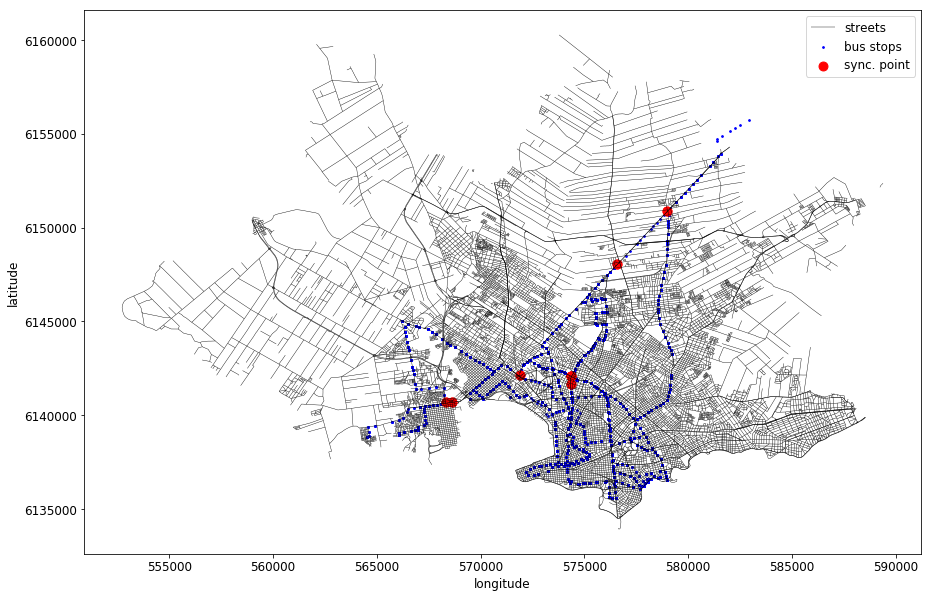

In [105]:

gdf_bus_stops=gpd.read_file("files/v_uptu_paradas/v_uptu_paradas.shp")
#gdf_bus_stops=gdf_bus_stops.to_crs(epsg=4326) 
gdf_streets=gpd.read_file("files/v_mdg_vias/v_mdg_vias.shp")
#gdf_streets=gdf_streets.to_crs(epsg=4326) 
bus_schedules_by_stops_aux = bus_schedules_by_stops.copy()
bus_schedules_by_stops_aux = bus_schedules_by_stops_aux.groupby(['cod_variante','cod_ubic_parada'], sort=False).max().reset_index()
bus_schedules_by_stops_aux = pd.merge(bus_schedules_by_stops_aux, frequency, 
                 how='right', left_on=['cod_variante'], right_on=['linea'])
gdf_bus_stops = pd.merge(gdf_bus_stops, bus_schedules_by_stops_aux, 
                 how='right', left_on=['COD_UBIC_P'], right_on=['cod_ubic_parada'])

geometry = transfers_with_stop_coors['line_1_geometry']
crs = {'init': 'epsg:4326'}
syncs1 = gpd.GeoDataFrame(transfers_with_stop_coors, crs=crs, geometry=geometry)
geometry = transfers_with_stop_coors['line_2_geometry']
crs = {'init': 'epsg:4326'}
syncs2 = gpd.GeoDataFrame(transfers_with_stop_coors, crs=crs, geometry=geometry)


fig, ax = plt.subplots(figsize=(15, 10))

gdf_streets.plot(ax=ax,
                linewidth=0.4,
                color="black",
                label="streets")


gdf_bus_stops.plot(ax=ax,
                   color="blue",
                markersize=3,
              label="bus stops")

syncs = syncs1.append(syncs2)

syncs.plot(ax=ax,
                   color="red",
                markersize=80,
              label="sync. point")


plt.legend()
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.rcParams.update({'font.size': 12})
#display(gdf_bus_stops.head())


plt.savefig("figs/paradas_buses.png", bbox_inches='tight')


